In [27]:
# نصب کتابخانه‌های ضروری
!pip install librosa
!pip install matplotlib
!pip install numpy
!pip install scipy


In [28]:

# وارد کردن کتابخانه‌ها
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from scipy.stats import skew, kurtosis

In [29]:
# اگر دیتاست در Google Drive است، ابتدا Google Drive را متصل کنید
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
%cd /content/gdrive/MyDrive/SourceKaravi/NTK.Education.Practice/
!git pull
%cd /content/gdrive/MyDrive/SourceKaravi/NTK.Education.Practice/PatternRecognition/6-14030828

/content/gdrive/MyDrive/SourceKaravi/NTK.Education.Practice
Already up to date.
/content/gdrive/MyDrive/SourceKaravi/NTK.Education.Practice/PatternRecognition/6-14030828


In [31]:
# بارگذاری دیتاست صوتی
file_path = 'jazz.wav'  # مسیر فایل صوتی خود را وارد کنید
y, sr = librosa.load(file_path, sr=None)


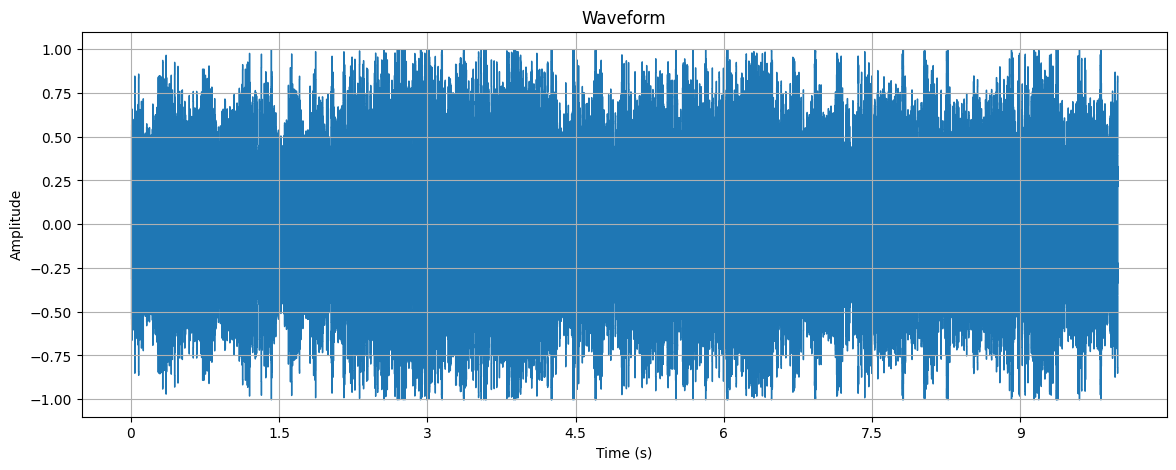

In [33]:

# سیگنال کردن
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

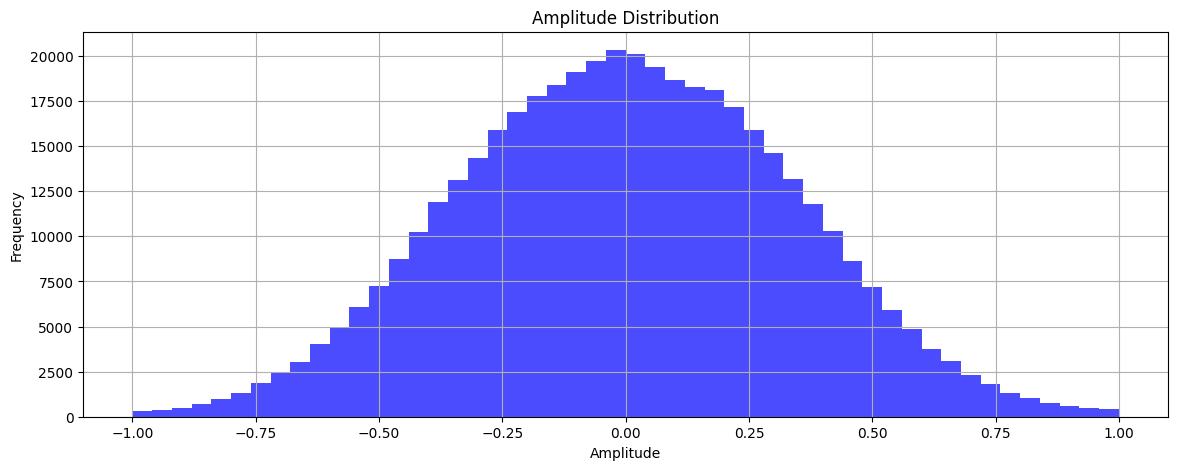

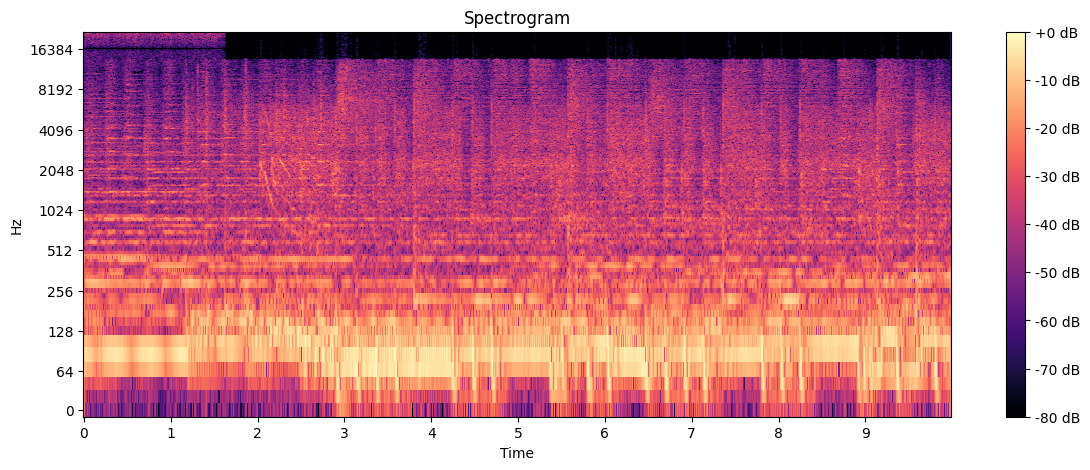

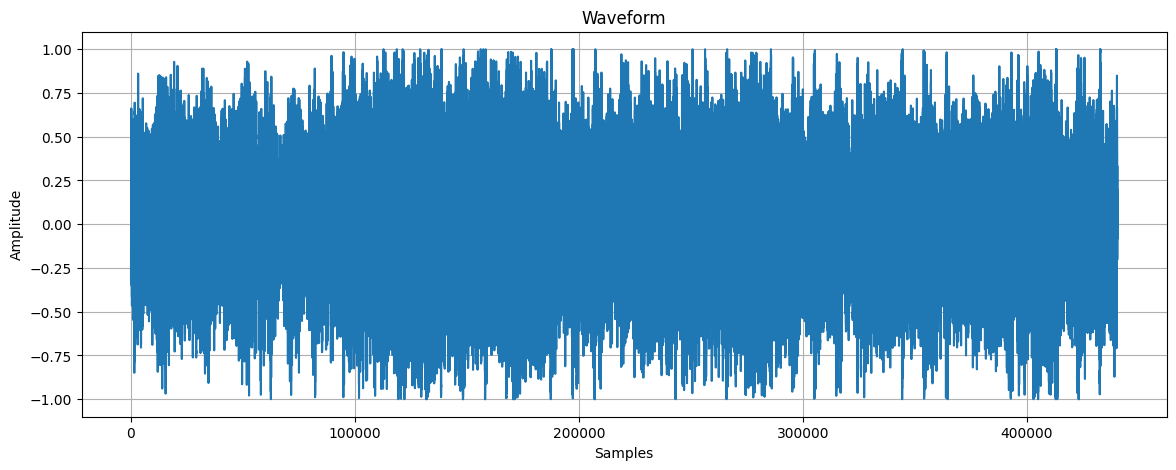

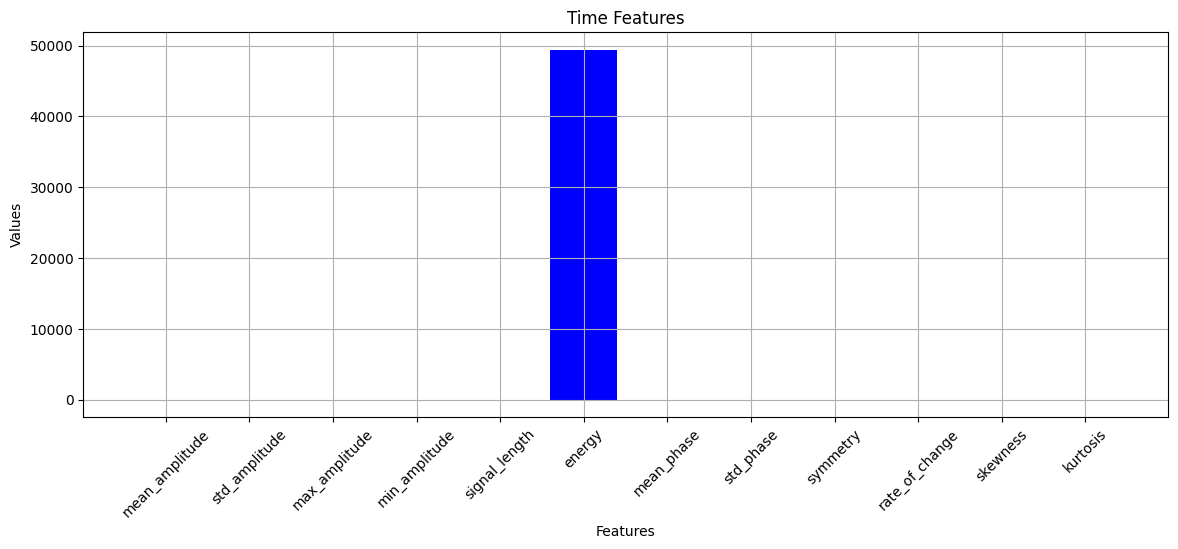

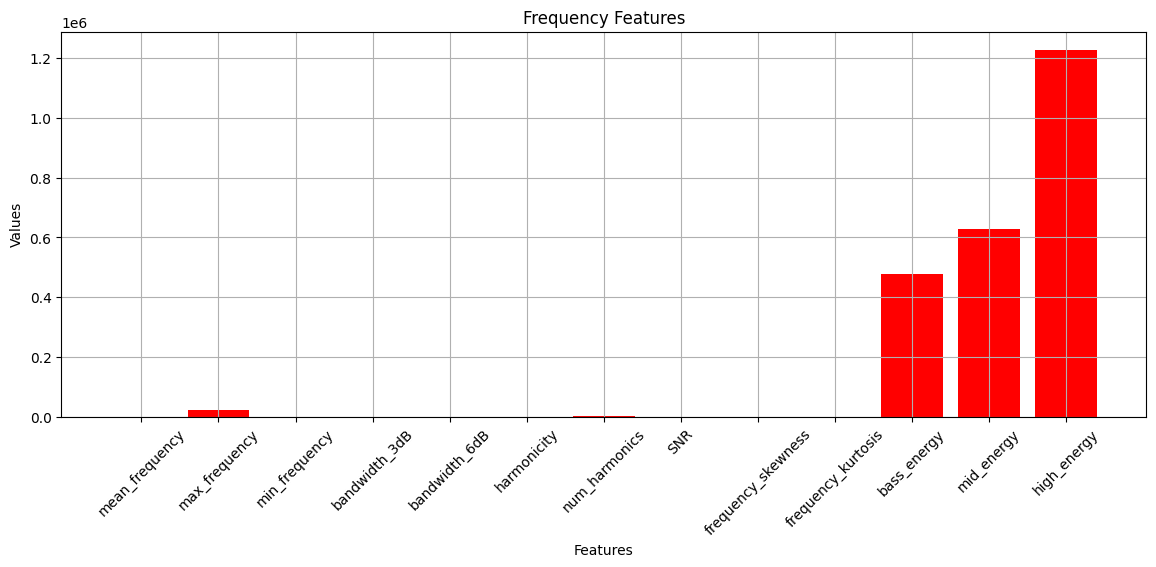

Time Features:
mean_amplitude: 4.292246376280673e-05
std_amplitude: 0.335003525018692
max_amplitude: 0.999969482421875
min_amplitude: -1.0
signal_length: 9.984761904761905
start_time: 0
end_time: 9.984761904761905
symmetry: 0.00843207973978478
rate_of_change: 0.05662462115287781
skewness: 0.008432079108458666
kurtosis: -0.2676515826338961
energy: 49416.84375
mean_phase: 0.0029594101943075657
std_phase: 1.8141423463821411

Frequency Features:
mean_frequency: 86.06319427490234
max_frequency: 22241.03515625
min_frequency: 0.0007393628475256264
bandwidth_3dB: 3
bandwidth_6dB: 4
harmonicity: 0.09004186419167026
num_harmonics: 825
SNR: -0.0019534567193798327
frequency_skewness: 14.53152051928844
frequency_kurtosis: 289.10894775489885
bass_energy: 476886.34375
mid_energy: 629420.8125
high_energy: 1227541.375


In [37]:

# ویژگی‌های زمانی
def extract_time_features(y):
    time_features = {}

    # آمپلی‌تود
    time_features['mean_amplitude'] = np.mean(y)
    time_features['std_amplitude'] = np.std(y)
    time_features['max_amplitude'] = np.max(y)
    time_features['min_amplitude'] = np.min(y)

    # زمان
    time_features['signal_length'] = len(y) / sr  # طول سیگنال به ثانیه
    time_features['start_time'] = 0  # زمان شروع
    time_features['end_time'] = time_features['signal_length']  # زمان پایان

    # خصیصه‌های شکل موج
    time_features['symmetry'] = np.sum((y - time_features['mean_amplitude'])**3) / (len(y) * (time_features['std_amplitude']**3))
    time_features['rate_of_change'] = np.mean(np.abs(np.diff(y)))

    # ویژگی‌های آماری
    time_features['skewness'] = skew(y)
    time_features['kurtosis'] = kurtosis(y)

    # توزیع آمپلی‌تود
    plt.figure(figsize=(14, 5))
    plt.hist(y, bins=50, alpha=0.7, color='b')
    plt.title('Amplitude Distribution')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

    # انرژی
    time_features['energy'] = np.sum(y**2)

    # زاویه فاز
    phase = np.angle(librosa.stft(y))
    time_features['mean_phase'] = np.mean(phase)
    time_features['std_phase'] = np.std(phase)

    return time_features

# ویژگی‌های فرکانسی
def extract_frequency_features(y, sr):
    D = librosa.stft(y)
    frequencies = np.abs(D)

    frequency_features = {}

    # طیف قدرت
    power_spectrum = np.mean(frequencies**2, axis=1)

    # فرکانس‌ها
    frequency_features['mean_frequency'] = np.mean(power_spectrum)
    frequency_features['max_frequency'] = np.max(power_spectrum)
    frequency_features['min_frequency'] = np.min(power_spectrum)

    # عرض باند
    frequency_features['bandwidth_3dB'] = np.sum(power_spectrum > 0.5 * np.max(power_spectrum))
    frequency_features['bandwidth_6dB'] = np.sum(power_spectrum > (1/4) * np.max(power_spectrum))

    # ویژگی‌های فرکانسی
    frequency_features['harmonicity'] = np.mean(power_spectrum) / (np.std(power_spectrum) + 1e-10)
    frequency_features['num_harmonics'] = len([f for f in power_spectrum if f > 0.1])

    # نسبت سیگنال به نویز (SNR)
    noise = np.random.normal(0, np.std(y), len(y))
    snr = 10 * np.log10(np.sum(y**2) / np.sum(noise**2))
    frequency_features['SNR'] = snr

    # چولگی و کشیدگی
    frequency_features['frequency_skewness'] = skew(frequencies.flatten())
    frequency_features['frequency_kurtosis'] = kurtosis(frequencies.flatten())

    # باندهای فرکانسی
    bass = np.sum(frequencies[:int(200 / (sr / 2) * len(frequencies))])
    mid = np.sum(frequencies[int(200 / (sr / 2) * len(frequencies)):int(2000 / (sr / 2) * len(frequencies))])
    high = np.sum(frequencies[int(2000 / (sr / 2) * len(frequencies)):])

    frequency_features['bass_energy'] = bass
    frequency_features['mid_energy'] = mid
    frequency_features['high_energy'] = high

    # طیف زمان-فرکانس
    plt.figure(figsize=(14, 5))
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    return frequency_features

# استخراج ویژگی‌ها
time_features = extract_time_features(y)
frequency_features = extract_frequency_features(y, sr)

# رسم ویژگی‌های زمانی
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# رسم ویژگی‌های زمانی
time_feature_labels = ['mean_amplitude', 'std_amplitude', 'max_amplitude', 'min_amplitude',
                       'signal_length', 'energy', 'mean_phase', 'std_phase',
                       'symmetry', 'rate_of_change', 'skewness', 'kurtosis']
time_feature_values = [time_features[label] for label in time_feature_labels]

plt.figure(figsize=(14, 5))
plt.bar(time_feature_labels, time_feature_values, color='b')
plt.title('Time Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# رسم ویژگی‌های فرکانسی
frequency_feature_labels = ['mean_frequency', 'max_frequency', 'min_frequency',
                            'bandwidth_3dB', 'bandwidth_6dB', 'harmonicity',
                            'num_harmonics', 'SNR', 'frequency_skewness',
                            'frequency_kurtosis', 'bass_energy', 'mid_energy',
                            'high_energy']
frequency_feature_values = [frequency_features[label] for label in frequency_feature_labels]

plt.figure(figsize=(14, 5))
plt.bar(frequency_feature_labels, frequency_feature_values, color='r')
plt.title('Frequency Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# نمایش ویژگی‌ها
print("Time Features:")
for key, value in time_features.items():
    print(f"{key}: {value}")

print("\nFrequency Features:")
for key, value in frequency_features.items():
    print(f"{key}: {value}")

In [ ]:
# ### توضیحات مربوط به ویژگی‌ها
# #### ویژگی‌های زمانی:
# 1. آمپر (Amplitude):
#    - میانگین آمپلی‌تود: میانگین مقادیر سیگنال، نشان‌دهنده سطح عمومی صدا.
#    - انحراف معیار آمپلی‌تود: میزان تغییرات آمپلی‌تود، نشان‌دهنده تغییرات در شدت صدا.
#    - حداکثر آمپلی‌تود: بالاترین مقدار سیگنال، نشان‌دهنده اوج صدا.
#    - حداقل آمپلی‌تود: پایین‌ترین مقدار سیگنال، نشان‌دهنده سکوت یا صدای بسیار کم.

# 2. زمان:
#    - طول سیگنال: مدت زمان کلی سیگنال به ثانیه.
#    - زمان شروع و پایان: زمان‌هایی که سیگنال شروع و پایان می‌یابد.

# 3. خصیصه‌های شکل موج:
#    - میزان تقارن: چگونگی تقارن شکل موج نسبت به محور x.
#    - نرخ تغییرات (Rate of change): متوسط تغییرات سیگنال در واحد زمان.

# 4. ویژگی‌های آماری:
#    - چولگی (Skewness): میزان عدم تقارن توزیع داده‌ها.
#    - کشیدگی (Kurtosis): میزان تمرکز داده‌ها در اطراف میانگین.

# 5. ویژگی‌های توزیع:
#    - توزیع آمپلی‌تود: نحوه توزیع مقادیر آمپلی‌تود.

# 6. انرژی:
#    - انرژی سیگنال: مجموع مربعات مقادیر سیگنال.
#    - انرژی در بخش‌های مختلف زمان: انرژی سیگنال در زمان‌های مختلف.

# 7. زاویه فاز:
#    - زاویه فاز میانگین: میانگین زاویه‌های فاز سیگنال.
#    - انحراف معیار زاویه فاز: میزان تغییرات زاویه فاز.

# #### ویژگی‌های فرکانسی:
# 1. طیف (Spectrum):
#    - طیف قدرت (Power Spectrum): نشان‌دهنده توزیع قدرت سیگنال در فرکانس‌های مختلف.
#    - طیف چگالی انرژی (Energy Density Spectrum): توزیع انرژی سیگنال در فرکانس‌های مختلف.

# 2. فرکانس:
#    - فرکانس میانگین: میانگین مقادیر فرکانس.
#    - حداکثر فرکانس: بالاترین مقدار فرکانس.
#    - حداقل فرکانس: پایین‌ترین مقدار فرکانس.

# 3. عرض باند:
#    - عرض باند 3 دسی‌بل: نشان‌دهنده محدوده فرکانسی که قدرت سیگنال در آن بالاتر از 3 دسی‌بل است.
#    - عرض باند 6 دسی‌بل: نشان‌دهنده محدوده فرکانسی که قدرت سیگنال در آن بالاتر از 6 دسی‌بل است.

# 4. ویژگی‌های فرکانسی:
#    - میزان هارمونیک (Harmonicity): نسبت میانگین قدرت به انحراف معیار قدرت.
#    - تعداد هارمونیک‌ها: تعداد فرکانس‌های بالاتر از آستانه مشخص.

# 5. نسبت سیگنال به نویز (SNR):
#    - نسبت سیگنال به نویز: میزان قدرت سیگنال نسبت به نویز در فرکانس‌های مختلف.

# 6. چولگی و کشیدگی فرکانسی:
#    - چولگی فرکانسی: میزان عدم تقارن توزیع داده‌های فرکانسی.
#    - کشیدگی فرکانسی: میزان تمرکز داده‌های فرکانسی در اطراف میانگین.

# 7. باندهای فرکانسی:
#    - انرژی در باندهای فرکانسی خاص: انرژی سیگنال در باندهای بیس، مید و های.

# 8. طیف زمان-فرکانس:
#    - ویژگی‌های استخراج شده از موجک‌ها (Wavelet Transform): قابلیت تحلیل سیگنال در زمان و فرکانس به طور همزمان.